## Logistic regression section

In [7]:

#Imports
#import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, log_loss
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sns
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt 
import pandas_profiling
import sweetviz

import dtale
#dtale.USE_COLAB = True

import statsmodels.api as sm


# Get and prepare data
- The initial preprocessing of the data file now handled collectively in data folder. 

In [8]:
## generate full url
#cur_path = os.path.dirname(__file__)
#url = os.path.join(cur_path, '..', 'data', 'training.zip')
#saveurl = os.path.join(cur_path, 'lcl.csv')
## github url
#url = 'https://raw.githubusercontent.com/NPF-classifiers-109/npf-classifier/data/npf_train.zip'
##local directory 
# #url = './npf-classifier/data/npf_train.zip'

## load data
#df = pd.read_csv(url,parse_dates=[0])
#df = pd.read_csv(url,index_col=0,parse_dates=[0])
###  Swap fr ipynb

### Try with diferent datasets
## Original
df = pd.read_csv('../data/training.zip', compression='zip')
## PreCleaned for outliers
#df = pd.read_csv('../data/training_cleansed.zip', compression='zip')
## Less features and no outliers
#df = pd.read_csv('../data/small_training_cleansed.zip', compression='zip')

# Take copy of dataset for later comparisons
df_copy = df.copy()
# Columns, rows
print(df.shape)
print(df.columns)

(458, 101)
Index(['CO2168.mean', 'CO2168.std', 'CO2336.mean', 'CO2336.std', 'CO242.mean',
       'CO242.std', 'CO2504.mean', 'CO2504.std', 'Glob.mean', 'Glob.std',
       ...
       'T672.std', 'T84.mean', 'T84.std', 'UV_A.mean', 'UV_A.std', 'UV_B.mean',
       'UV_B.std', 'CS.mean', 'CS.std', 'class2'],
      dtype='object', length=101)


# Data exploration
Utilizing the packages from D-tale, Sweetwiz and Pandas Profiling
This is now copied to Explore and Cleanse in data folder 

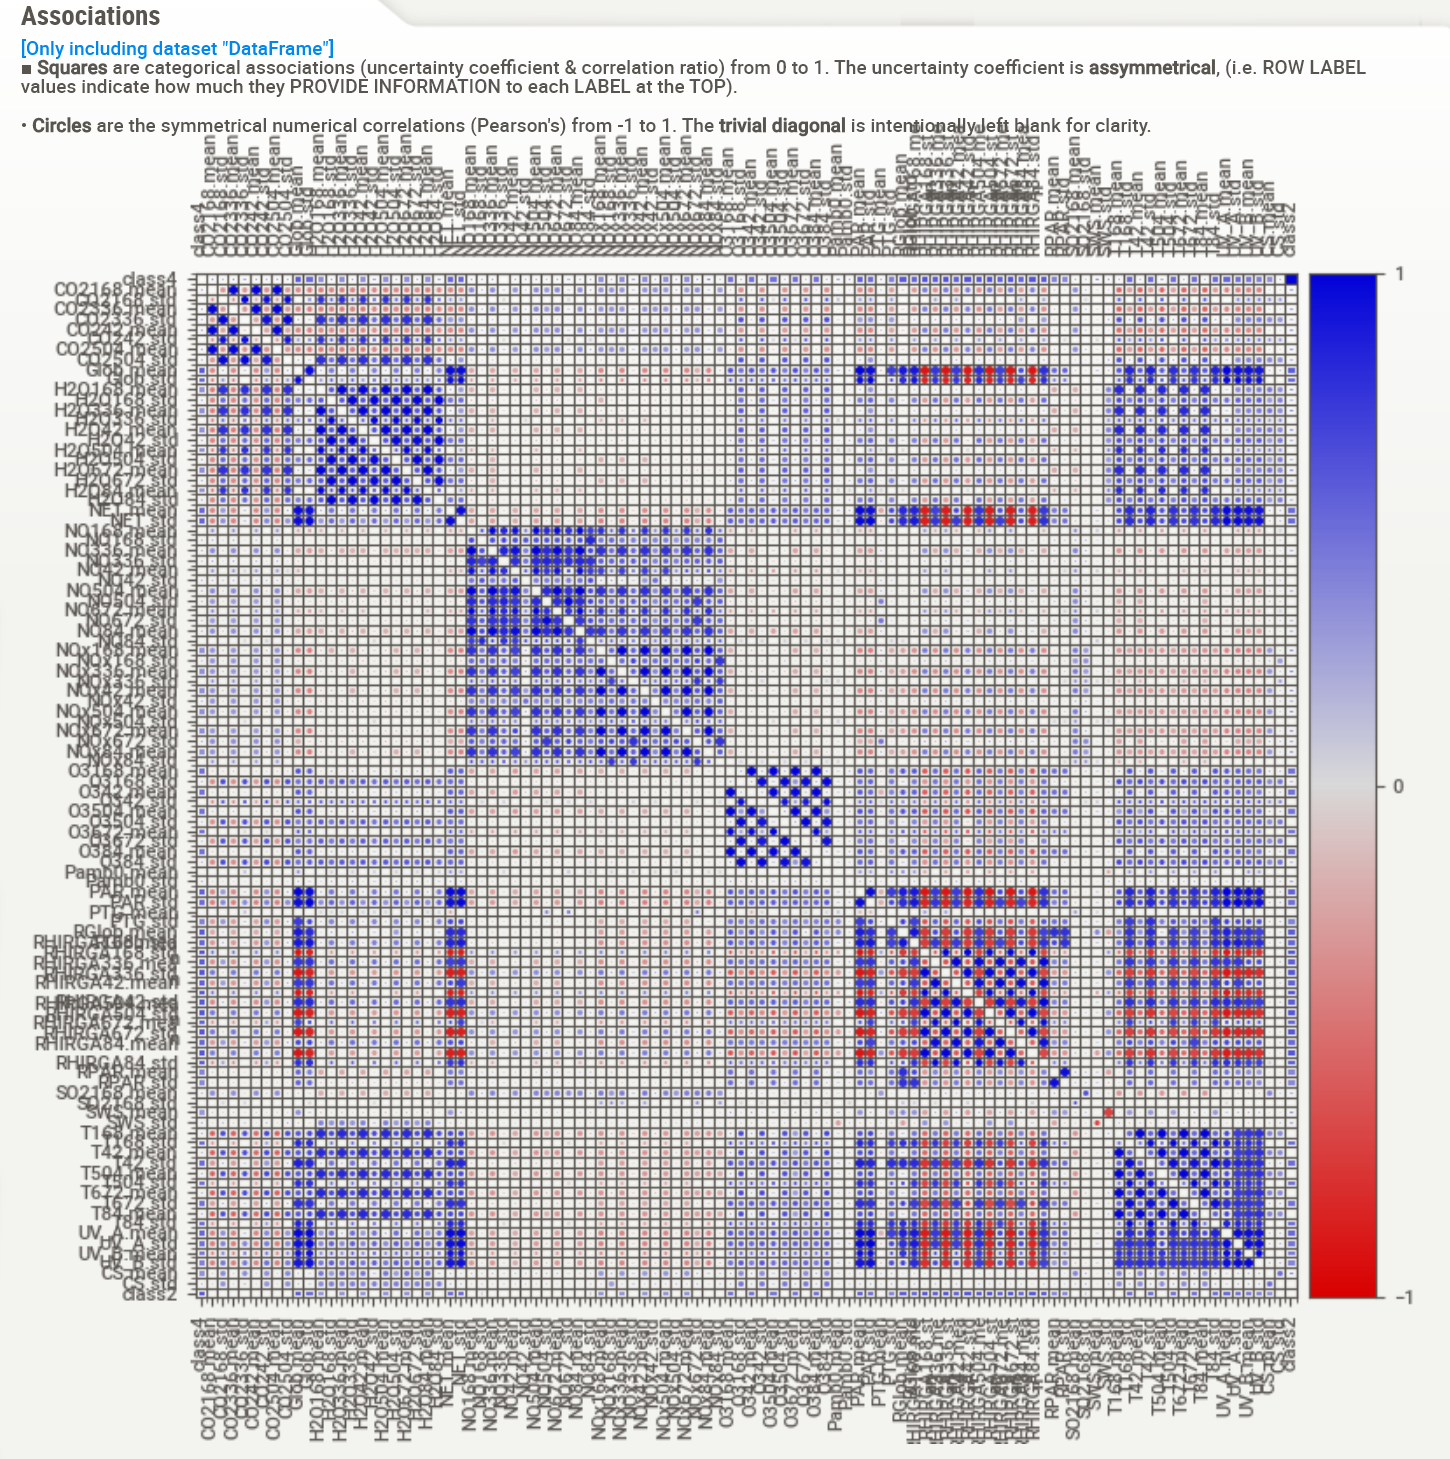

In [4]:
## dtale (d-tail)
dtale.show(open_browser=True)
d = dtale.show(df)
#d.open_browser()

In [11]:
##sweetwiz
# Generate report
my_report = sweetviz.analyze(df)
my_report.show_html('Report.html')
my_report.show_notebook('Report.html')

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:13 -> (00:00 left)


Report Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [40]:
##Pandas profiling (pls note this takes over 8 mins for all the features)
#df.profile_report()
profile=df.profile_report(title='Pandas profiling report')
profile.to_file(output_file='Profiling_Output.html')

Summarize dataset:  15%|█▌        | 1539/10112 [03:49<17:31,  8.15it/s, scatter NO672.mean, H2O42.mean]     

## Split for train & test and feature vs response separation

In [9]:
# pick class2 as response and others for features 
# (class4 removed already previously)
y = df['class2']
X = df.drop('class2',  axis=1)
#Split 30/70 for training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=0)
columns = X_train.columns

# Data Normalization 

In [10]:
# Normalize training data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

## Outliers detection and tapping
We will use Inter-Quartile Range (IQR) proximity rule as our data is partially skewed, more precisely
We will consider outliers the data points which fall 
below Q1 – 1.5 IQR or 
above Q3 + 1.5 IQR
where Q1 and Q3 are the 25th and 75th precentile and
IQR is the inter quartile range Q3-Q1

We will list the outliers and cap them to the allowed corresponding minimum/maximu

In [11]:
def outliers(df, cl_col):

    for columnName, columnData in df.iteritems():
        if columnName == ('class2' or 'class4'):
            continue
        #print(columnName)

    # Calculate percentiles
        percentile25 = columnData.quantile(0.25)
        percentile75 = columnData.quantile(0.75)
    # Calculate IQR
        iqr = percentile75 - percentile25
    # Upper and lower boundaries
        upper_limit = percentile75 + 1.5 * iqr
        lower_limit = percentile25 - 1.5 * iqr
        #print("Allowed Range",lower_limit, "-", upper_limit)
        
    # Find outliers
        for value in columnData:
            if value > upper_limit:
                print(columnName, ":", value, "over limit", " Range (", lower_limit, "-", upper_limit, ")")
                cl_col.add(columnName)
            if  value < lower_limit:
                print(columnName, ":", value, "below limit", lower_limit)
                cl_col.add(columnName)
    # Cap
        df[columnName] = np.where(
            df[columnName] > upper_limit,
            upper_limit,
            df[columnName])
        df[columnName] = np.where(
            df[columnName] < lower_limit,
            lower_limit,
            df[columnName]
        )

cleaned_columns = set()
cleaned_columns_feature_select = set()
    
outliers(X, cleaned_columns)


if len(cleaned_columns) == 0:
    print("Nothing cleansed")
else:
    print("Columns cleansed", len(cleaned_columns))


CO2168.std : 11.8948227223593 over limit  Range ( -4.721295901470462 - 10.763553441162177 )
CO2168.std : 15.5908510403067 over limit  Range ( -4.721295901470462 - 10.763553441162177 )
CO2168.std : 10.961206951870198 over limit  Range ( -4.721295901470462 - 10.763553441162177 )
CO2168.std : 17.1608762026332 over limit  Range ( -4.721295901470462 - 10.763553441162177 )
CO2168.std : 19.4605207623159 over limit  Range ( -4.721295901470462 - 10.763553441162177 )
CO2168.std : 16.4370589149916 over limit  Range ( -4.721295901470462 - 10.763553441162177 )
CO2168.std : 16.1352959633819 over limit  Range ( -4.721295901470462 - 10.763553441162177 )
CO2168.std : 10.8370058677322 over limit  Range ( -4.721295901470462 - 10.763553441162177 )
CO2168.std : 18.1997861331973 over limit  Range ( -4.721295901470462 - 10.763553441162177 )
CO2168.std : 13.391440202576302 over limit  Range ( -4.721295901470462 - 10.763553441162177 )
CO2168.std : 11.3418660377021 over limit  Range ( -4.721295901470462 - 10.76

In [13]:
    ##sweetwiz comparison for the cleansed features
    my_report_before = sweetviz.compare(df_copy[cleaned_columns], df[cleaned_columns])
    my_report_before.show_html('Initial vs Cleansed for Outliers.html')

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:11 -> (00:00 left)


Report Initial vs Cleansed for Outliers.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [12]:
print(cleaned_columns)

{'NOx504.std', 'NOx336.std', 'Pamb0.std', 'T504.std', 'T672.std', 'NOx84.mean', 'O3168.std', 'PTG.std', 'H2O336.std', 'SWS.std', 'NOx672.mean', 'H2O168.std', 'O384.mean', 'NOx336.mean', 'NO168.mean', 'RPAR.std', 'NO42.mean', 'H2O84.std', 'NO504.mean', 'NOx168.std', 'O3672.mean', 'PTG.mean', 'SO2168.std', 'CO2504.std', 'NO84.std', 'O342.std', 'SO2168.mean', 'NO84.mean', 'H2O42.std', 'NO168.std', 'NOx504.mean', 'SWS.mean', 'H2O672.std', 'NO42.std', 'CO2168.std', 'NO504.std', 'NOx168.mean', 'NO672.std', 'O3168.mean', 'CS.mean', 'NOx42.std', 'H2O504.std', 'NO672.mean', 'NOx42.mean', 'CS.std', 'NOx84.std', 'NO336.std', 'Pamb0.mean', 'O3504.std', 'O3672.std', 'RPAR.mean', 'O384.std', 'O342.mean', 'CO2336.std', 'NO336.mean', 'CO242.std', 'O3504.mean', 'NOx672.std'}


## Feature Selection
Feature selection is prepared using both the previous inputs from data exploration and initial feature reduction done previously for the data in the prior steps witin the data folder. For the remaining attributes, we will use the automated Recursive Feature Elimination (RFE) to rank and choose the best set of features for validation on accuracy, perplexity and crossvalidation.
RFE is based on the idea to starting with all features in the dataset and repeatedly construct a model and choose either the best or worst performing feature discarding the least important features, and re-fitting the model until the desired number of features remains. RFE is well suitable for also skewed, non Gaussian data, much like we have.

In [14]:
# Run Recursive Feature Elimination (RFE) for each combination of number of attributes and report results
# we do this for all attributes in chosen dataset, which will take a while for the original dataset

def perplexity(y_true, y_pred_proba):
    # return np.exp(-np.mean(np.log((y_true == 1) * y_pred_proba + (y_true == 0) * (1 - y_pred_proba))))
    return np.exp(np.mean(log_loss(y_test, y_pred_proba)))


#RFECV()
def feature_selection(features_number):
    #features_chosen = 8
    results = []
    #print("Running for top ", features_chosen, "features")
    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LogisticRegression

    # RFE with logistic regression as the model
    #rfe = RFE(estimator=LogisticRegression())
    rfe = RFE(LogisticRegression(), n_features_to_select=features_number)
    #rfe = RFECV(estimator=LogisticRegression())

    rfe = rfe.fit(X_train, y_train.values.ravel())

    # summarize all features results
    chosen_features = []
    #for i in range(X_train.shape[1]):
    #	print('Column: %d, %s, Selected %s, Rank: %.3f' % (i, X_train.columns[i], rfe.support_[i], rfe.ranking_[i]))
    for i in range(X_train.shape[1]):    
        if rfe.support_[i] == True:
            chosen_features.append(X_train.columns[i])
    X_train_chosen_features = X_train[chosen_features]

    # Test to fit the logistic regression model on the chosen features and report
    logreg = LogisticRegression()
    logreg.fit(X_train_chosen_features, y_train)
    ## Predict on chosen features
    # Training data
    y_pred_train = logreg.predict(X_train_chosen_features)
    # Test data
    X_test_chosen_features = X_test[chosen_features]
    y_pred_test = logreg.predict(X_test_chosen_features)
    y_pred_test_proba = logreg.predict_proba(X_test_chosen_features)
    
    #Calculate accuracy
    accuracy_train = '{:.2f}'.format(logreg.score(X_train_chosen_features, y_train))
    accuracy_test =  '{:.2f}'.format(logreg.score(X_test_chosen_features, y_test))
    # calculate perplexity
    perp = perplexity(y_test, y_pred_test_proba)

    # Cross validation  
    crvad = np.mean(cross_val_score(logreg, X_train_chosen_features, y_train, cv=10))

    return [features_number, accuracy_train, accuracy_test, perp, crvad]


res = []
for i in range(1,len(X_train.columns)+1):
    res.append(feature_selection(i))

featres = pd.DataFrame(res, columns=['Features', 'Train Accuracy', 'Test Accuracy', 'Perplexity', 'Crossvalidation'])
print(featres[1:20])

    features accuracy_train accuracy_test  perplexity  crossval
1          2           0.56          0.54    2.012214  0.556250
2          3           0.69          0.66    1.865344  0.687500
3          4           0.83          0.80    1.522115  0.831250
4          5           0.84          0.79    1.529696  0.831250
5          6           0.84          0.81    1.517677  0.837500
6          7           0.84          0.80    1.520525  0.831250
7          8           0.84          0.80    1.521561  0.831250
8          9           0.84          0.81    1.521928  0.834375
9         10           0.84          0.82    1.521431  0.834375
10        11           0.86          0.83    1.500075  0.837500
11        12           0.86          0.81    1.484695  0.837500
12        13           0.85          0.81    1.452915  0.831250
13        14           0.85          0.81    1.453511  0.831250
14        15           0.85          0.81    1.453285  0.831250
15        16           0.85          0.8

After analyzing the accuracy, perplexity and crossvalidation score, we can see that the optimal number of features would be around 8 or less. Let´s pick up those features and have a closed look at their performance.

In [34]:
print(featres[40:90])


    features accuracy_train accuracy_test  perplexity  crossval
40        41           0.87          0.86    1.450476  0.831250
41        42           0.88          0.85    1.380799  0.846875
42        43           0.88          0.83    1.408862  0.846875
43        44           0.88          0.85    1.387640  0.840625
44        45           0.89          0.83    1.393846  0.843750
45        46           0.88          0.83    1.415316  0.843750
46        47           0.88          0.84    1.388096  0.837500
47        48           0.88          0.84    1.384485  0.843750
48        49           0.88          0.85    1.395513  0.837500
49        50           0.88          0.83    1.390653  0.834375
50        51           0.87          0.86    1.378989  0.831250
51        52           0.86          0.84    1.380172  0.831250
52        53           0.87          0.86    1.381314  0.834375
53        54           0.87          0.83    1.377133  0.837500
54        55           0.88          0.8

In [35]:

features_chosen = 42
print("Running for top ", features_chosen, "features")
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

rfe = RFE(LogisticRegression(), n_features_to_select=features_chosen)
rfe = rfe.fit(X_train, y_train.values.ravel())

# summarize all features results
chosen_features = []
#for i in range(X_train.shape[1]):
#	print('Column: %d, %s, Selected %s, Rank: %.3f' % (i, X_train.columns[i], rfe.support_[i], rfe.ranking_[i]))
for i in range(X_train.shape[1]):    
    if rfe.support_[i] == True:
        chosen_features.append(X_train.columns[i])
X_train_chosen_features = X_train[chosen_features]

#print features in rank order defining the selected ones
sorted_list = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), X_train.columns, rfe.support_))

for ra, co, bi in sorted_list:
    print("Column:", co, "\t", "Rank:", ra, "\t", "Selected:", bi, "\t", "ColumnId:", X_train.columns.get_loc(co))


Running for top  42 features
Column: CO2168.std 	 Rank: 1 	 Selected: True 	 ColumnId: 1
Column: CO2336.std 	 Rank: 1 	 Selected: True 	 ColumnId: 3
Column: CO242.std 	 Rank: 1 	 Selected: True 	 ColumnId: 5
Column: CO2504.mean 	 Rank: 1 	 Selected: True 	 ColumnId: 6
Column: CO2504.std 	 Rank: 1 	 Selected: True 	 ColumnId: 7
Column: H2O168.mean 	 Rank: 1 	 Selected: True 	 ColumnId: 10
Column: H2O336.mean 	 Rank: 1 	 Selected: True 	 ColumnId: 12
Column: H2O42.mean 	 Rank: 1 	 Selected: True 	 ColumnId: 14
Column: H2O504.mean 	 Rank: 1 	 Selected: True 	 ColumnId: 16
Column: H2O672.mean 	 Rank: 1 	 Selected: True 	 ColumnId: 18
Column: H2O84.mean 	 Rank: 1 	 Selected: True 	 ColumnId: 20
Column: NOx168.mean 	 Rank: 1 	 Selected: True 	 ColumnId: 36
Column: NOx336.mean 	 Rank: 1 	 Selected: True 	 ColumnId: 38
Column: NOx336.std 	 Rank: 1 	 Selected: True 	 ColumnId: 39
Column: NOx42.mean 	 Rank: 1 	 Selected: True 	 ColumnId: 40
Column: NOx504.mean 	 Rank: 1 	 Selected: True 	 Column

Feature selection results - P-values

In [36]:
# Run model and get summary for chosen variables
logit_model=sm.Logit(y_train,X_train_chosen_features)
result=logit_model.fit()
# let´s see the p-values
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.294865
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.573     
Dependent Variable: class2           AIC:              272.7134  
Date:               2021-12-20 10:12 BIC:              430.9829  
No. Observations:   320              Log-Likelihood:   -94.357   
Df Model:           41               LL-Null:          -221.05   
Df Residuals:       278              LLR p-value:      2.0911e-32
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-----------------------------------------------------------------
                 Coef.   Std.Err.    z    P>|z|   [0.025   0.975]
-----------------------------------------------------------------
CO2168.std       -1.0480   1.1036 -0.9495 0.3423  -3.2111  1.1151
CO2336.std        1.6327   1.7176  0.9506 0.3418  -1.7336  4.9991


We choose the k desired number of attributes, 
by going through different k and p-values combinations
Rerunning until satisfied, for our data and variables, we use rfe with k = 8
However, we will further remove the 'H2O672.mean' and 'UV_A.mean' due to their large p-values

In [29]:
to_remove = ['H2O672.mean', 'UV_A.mean']
chosen_features = [x for x in chosen_features if x not in to_remove]

X_train_chosen_features = X_train[chosen_features]
# Run model and get summary for chosen variables
logit_model=sm.Logit(y_train,X_train_chosen_features)
result=logit_model.fit()
# let´s see the p-values
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.261023
         Iterations 9
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.622     
Dependent Variable: class2           AIC:              277.0547  
Date:               2021-12-20 10:03 BIC:              484.3124  
No. Observations:   320              Log-Likelihood:   -83.527   
Df Model:           54               LL-Null:          -221.05   
Df Residuals:       265              LLR p-value:      2.2742e-31
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     9.0000                                       
-----------------------------------------------------------------
                 Coef.   Std.Err.    z    P>|z|   [0.025   0.975]
-----------------------------------------------------------------
CO2168.std       -1.2373   0.9861 -1.2547 0.2096  -3.1701  0.6955
CO2336.mean       2.3377   1.5335  1.5245 0.1274  -0.6678  5.3432


## Logistic Regression
Let´s run Logistic regression and see how accurate out model is on the training data and ultimately on the test set.
Then we can see how our classifier did on the classes as our predictions are plotted into the Confusion Matrix


Accuracy of logistic regression classifier on training set: 0.88
Accuracy of logistic regression classifier on test set: 0.85


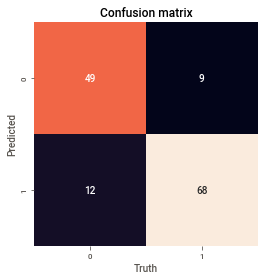

In [37]:

# Fit the logistic regression model on the chosen features and report
logreg = LogisticRegression()
logreg.fit(X_train_chosen_features, y_train)
## Predict on chosen features
# Training data
y_pred_train = logreg.predict(X_train_chosen_features)
# Test data
X_test_chosen_features = X_test[chosen_features]
y_pred_test = logreg.predict(X_test_chosen_features)
y_pred_test_proba = logreg.predict_proba(X_test_chosen_features)

# print resuts (accuracy and classification report)
print('Accuracy of logistic regression classifier on training set: {:.2f}'.format(logreg.score(X_train_chosen_features, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_chosen_features, y_test)))

## Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_test.tolist(), y_pred_test.tolist())

#Plot Confusion Matrix
class_names=[0,1]
names = np.unique(y_pred_test)
sns.heatmap(conf_matrix, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=names, yticklabels=names)
plt.xlabel('Truth')
plt.ylabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()
plt.show()



Let´s look into the details of this classification results on the test set

# Precision
The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is the ability of the classifier to not label a sample as positive if it is negative.
# Recall
The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is the ability of the classifier to find all the positive samples.
# F1-score
The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall. 1 Would be ideal where precision and recall are equally important whereas 0 would be the worst.

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82        58
           1       0.88      0.85      0.87        80

    accuracy                           0.85       138
   macro avg       0.84      0.85      0.84       138
weighted avg       0.85      0.85      0.85       138



In [40]:

def perplexity(y_true, y_pred_proba):
    # return np.exp(-np.mean(np.log((y_true == 1) * y_pred_proba + (y_true == 0) * (1 - y_pred_proba))))
    return np.exp(np.mean(log_loss(y_test, y_pred_proba)))


print("Perplexity: ", perplexity(y_test, y_pred_test_proba))

# Cross validation result of 10 sets
np.mean(cross_val_score(logreg, X_train_chosen_features, y_train, cv=10))

Perplexity:  1.3807991343517911


0.846875


Our classifier has equal distribution of false negatives and positives and does not seem too skewed to predict either class incorrectly, thus we have a high F1-score, however as we do have a larger count of 1s in our test set, the precision and recall are higher for the 1s. We have reached a reasonably good accuracy of 86% on the test set. 

# ROC Curve
The dotted line represents the ROC curve of a purely random classifier, 
whereas the blue line is our classifier. 

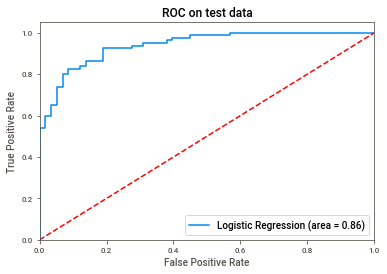

In [33]:

# Receiver operating characteristic ROC curve
%matplotlib inline

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test_chosen_features))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_chosen_features)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC on test data')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Altogether we have managed fairly well with our Logistic regresson classifier, especially on a dataset with trimmed Outliers (as per the previous cleansing done in the data folder scripts).

## Predict hidden data
Now will use our model for predicting the hidden data

# Load and preprocess data to suit model

In [51]:
# Load data
data = pd.read_csv('../data/npf_test_hidden.zip', compression='zip')
print(data.shape)
print(data.columns)

# Fix  date as index and remove obsolete categories
data = data.set_index('date')
data = data.drop(['id', 'partlybad', 'class4'], axis=1)
print(data.shape)
print(data.columns)


(965, 104)
Index(['id', 'date', 'class4', 'partlybad', 'CO2168.mean', 'CO2168.std',
       'CO2336.mean', 'CO2336.std', 'CO242.mean', 'CO242.std',
       ...
       'T672.mean', 'T672.std', 'T84.mean', 'T84.std', 'UV_A.mean', 'UV_A.std',
       'UV_B.mean', 'UV_B.std', 'CS.mean', 'CS.std'],
      dtype='object', length=104)
(965, 100)
Index(['CO2168.mean', 'CO2168.std', 'CO2336.mean', 'CO2336.std', 'CO242.mean',
       'CO242.std', 'CO2504.mean', 'CO2504.std', 'Glob.mean', 'Glob.std',
       'H2O168.mean', 'H2O168.std', 'H2O336.mean', 'H2O336.std', 'H2O42.mean',
       'H2O42.std', 'H2O504.mean', 'H2O504.std', 'H2O672.mean', 'H2O672.std',
       'H2O84.mean', 'H2O84.std', 'NET.mean', 'NET.std', 'NO168.mean',
       'NO168.std', 'NO336.mean', 'NO336.std', 'NO42.mean', 'NO42.std',
       'NO504.mean', 'NO504.std', 'NO672.mean', 'NO672.std', 'NO84.mean',
       'NO84.std', 'NOx168.mean', 'NOx168.std', 'NOx336.mean', 'NOx336.std',
       'NOx42.mean', 'NOx42.std', 'NOx504.mean', 'NOx504.st

In [89]:
## Predict on hidden data with the model and chosen features
print([chosen_features])
# Training data
y_pred_hidden = logreg.predict(data[chosen_features])
y_pred_hidden_proba = logreg.predict_proba(data[chosen_features])
# Test data
#X_test_chosen_features = X_test[chosen_features]
#y_pred_test = logreg.predict(X_test_chosen_features)
#y_pred_test_proba = logreg.predict_proba(X_test_chosen_features)
print(logreg.classes_)
print(y_pred_hidden[1:10])
print(y_pred_hidden_proba[1:10])




[['CO2504.mean', 'NOx672.mean', 'O3672.mean', 'RHIRGA672.mean', 'SWS.mean', 'T672.mean']]
[0 1]
[0 1 1 0 1 0 0 1 1]
[[0.5404425  0.4595575 ]
 [0.0525225  0.9474775 ]
 [0.1827458  0.8172542 ]
 [0.99018628 0.00981372]
 [0.01780188 0.98219812]
 [0.98679528 0.01320472]
 [0.996489   0.003511  ]
 [0.09182591 0.90817409]
 [0.31402179 0.68597821]]


In [91]:
resu = []
for i in range(0,len(y_pred_hidden)):
    val = ''
    ppp = ''
    if y_pred_hidden[i] == 0:
        val = 'nonevent'
        ppp = round(y_pred_hidden_proba[i][0],3)
    else:
        val = 'II'
        ppp = round(y_pred_hidden_proba[i][1],3)
    
    row = (val,ppp)
    resu.append(row)

predres = pd.DataFrame(resu, columns=['class4', 'p'])
print(predres[1:10])    


     class4      p
1  nonevent  0.540
2        II  0.947
3        II  0.817
4  nonevent  0.990
5        II  0.982
6  nonevent  0.987
7  nonevent  0.996
8        II  0.908
9        II  0.686


In [86]:
# Save data
pd.DataFrame(predres).to_csv("../data/predictions109.csv", header='class4,p', index=None)
